# Twitter Sentiment Analysis Stock Price Prediction

### - Crawl data

### - Sentiment Analysis

### - Predict Stock

## Import module

In [1]:
from textblob import TextBlob
import math
from collections import Counter, defaultdict
import tweepy as tw
import json
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
%matplotlib inline
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score

## Set up token API

In [2]:
api_key = "HAcIeikl6eRheQP1oKYGDwPx0"
api_secret = "gEWmqG7QVXzudnviUXDo98L2UKGYg9PNqy1bAR1geClkHjqBGk"
access_token = "1481095074465579008-1pApYlU4HRJWpbAXcbdVEVGzdACuEz"
access_token_secret = "htgD81H4mOxXw5MglAljFRHhcfGAuwsNomXVqvGw0Obwe"
auth = tw.OAuthHandler(api_key, api_secret)
auth.set_access_token(access_token, access_token_secret)
api = tw.API(auth,wait_on_rate_limit=True)

## Crawl data

In [3]:
def apiSearch(kw, number_of_tweets, tweets, user_id, created_at):
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)

In [4]:
number_of_tweets = 100
tweets = []
user_id =[]
created_at = []
keyword_list = ['Finance', 'Shareholders', 'Stock', 'Soaring', 'Market', 'Trends']
company = 'Amazon'
final_kw_list = []

# Crawl data from keywords
for i in range (len(keyword_list)):
    kw = str(company + ' ' + keyword_list[i])
    print(kw)
    final_kw_list.append(kw)
    for i in tw.Cursor(api.search, q = kw , lang ="en", since = "2022-01-14",tweet_mode = "extended").items(number_of_tweets):
        tweets.append(i.full_text)
        user_id.append(i.user.id)
        created_at.append(i.created_at)



Amazon Finance
Amazon Shareholders
Amazon Stock
Amazon Soaring
Amazon Market
Amazon Trends


## Dataframe

In [5]:
df = pd.DataFrame({"Created_at": created_at,"User_id": user_id,"Tweets":tweets})
df

,Created_at,User_id,Tweets
0,2022-02-04 09:30:00,296791725,Amazon shares surge on Prime price rise\nhttps...
1,2022-02-04 09:20:46,2838885389,"In record net income quarter, super rich Bezos..."
2,2022-02-04 09:11:51,1308292956,RT @MePartel_embolo: @CoinDesk @steveaoki @tur...
3,2022-02-04 09:05:12,2838885389,WHY is Amazon hiking Prime membership fees in ...
4,2022-02-04 09:00:08,947551222550188032,I think we're coming back down to life in Amaz...
...,...,...,...
595,2022-02-02 17:57:49,58554518,Amazon is having a mini sale on Aftershokz hea...
596,2022-02-02 17:57:48,58554518,Every model of AirPods is on sale at Amazon ri...
597,2022-02-02 17:30:51,1162775438281891840,34MM Crystal Watch https://t.co/BtuBCLbYMe #wa...
598,2022-02-02 17:19:02,25494567,RT @ukaop: ONLY ONE WEEK LEFT to enter the AOP...


## Clean data

In [6]:
df = df[~df.Tweets.str.contains("RT")]
df = df.reset_index(drop = True)

In [7]:
def cleanUpTweet(text):
    text = re.sub(r'@[A-Za-z0-9_]+','',text) # Remove mentions @
    text = re.sub(r'#', '', text) # Remove hastag symbol
    text = re.sub(r'https?:\/\/[A-Za-z0-9\.\/]+', '', text) # Remove hyper link
    text = re.sub('[^A-Za-z0-9]+', ' ', text) # Remove special characters
    #Remove stop words
    res = ''
    for word in text.split():
        if word not in stopwords.words('english'):
            res += WordNetLemmatizer().lemmatize(word) + ' '
            
    return res

In [8]:
df['Tweets'] = df['Tweets'].apply(cleanUpTweet)
df = df.drop_duplicates(subset='Tweets')
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets
0,2022-02-04 09:30:00,296791725,Amazon share surge Prime price rise
1,2022-02-04 09:20:46,2838885389,In record net income quarter super rich Bezos ...
2,2022-02-04 09:05:12,2838885389,WHY Amazon hiking Prime membership fee U S ONL...
3,2022-02-04 09:00:08,947551222550188032,I think coming back life Amazon e commerce gro...
4,2022-02-04 08:59:01,2838885389,Amazon earned 14 3 billion quarter DOUBLE net ...
...,...,...,...
292,2022-02-02 18:04:13,1336247731589885955,It 19 000 employee This number manageable may ...
293,2022-02-02 17:57:49,58554518,Amazon mini sale Aftershokz headphone Trends
294,2022-02-02 17:57:48,58554518,Every model AirPods sale Amazon right Trends
295,2022-02-02 17:30:51,1162775438281891840,34MM Crystal Watch watch clock jewelry trend f...


## Create clean data list

In [9]:
cleaned_data=[]
for tw in df['Tweets']:
    cleaned_data.append(tw)
    
cleaned_data

['Amazon share surge Prime price rise ',
 'In record net income quarter super rich Bezos increasing Amazon Prime fee U S ONLY HOW MUCH Amazon getting corp subsidy COVID FROM US TAXPAYERS When Corp GREED TOO MUCH ',
 'WHY Amazon hiking Prime membership fee U S ONLY Amazon record PROFIT quarter Bezos net worth HUNDREDS OF BILLIONS Where financial EQUITY WHY get RICHER back middle class Americans ',
 'I think coming back life Amazon e commerce growth say Joe Feldman ',
 'Amazon earned 14 3 billion quarter DOUBLE net income year earlier Woke OWNER Jeff Bezos worth hundred BILLIONS decided rich enough time increase obscene wealth hiking Prime membership fee ',
 'Dogecola first crypto drink unites world cryoto real world QR code bottle win nft The drink made Italy Very soon also Amazon ',
 'Amazon raising price Prime 139 per year ',
 'Amazon stock soar 15 earnings hike Prime membership fee ',
 'GLOBAL MARKETS Amazon help stock steady prospect rate hike loom market Yahoo Finance stock news ',

## WordCloud Visualization

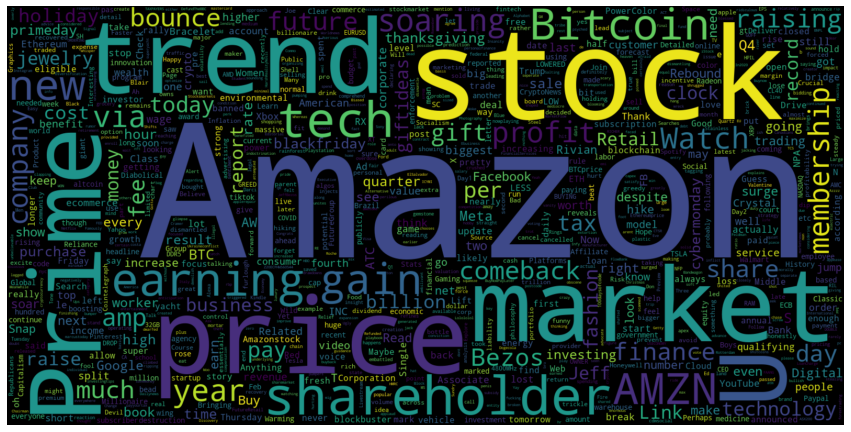

In [10]:
# Plot the word cloud 
allWords = ' '.join( [twts for twts in df['Tweets']] )
positiveWordCloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False).generate(allWords)
plt.figure(figsize = (15,15))
plt.imshow(positiveWordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()


## Sentiment Analysis

In [11]:
# Create function to get subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Function compute negative, positive
def getAnalysis(score):
    if score < 0: 
        return np.int_(0)
    elif score > 0:
        return np.int_(1)
    else:
        return 'Neutral'
    
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity)
df['Polarity'] = df['Tweets'].apply(getPolarity)
df['Sentiment'] = df['Polarity'].apply(getAnalysis)
df.drop(df.loc[df['Sentiment']=='Neutral'].index, inplace=True)
df = df.reset_index(drop=True)
df

,Created_at,User_id,Tweets,Subjectivity,Polarity,Sentiment
0,2022-02-04 09:20:46,2838885389,In record net income quarter super rich Bezos ...,0.469444,0.184722,1
1,2022-02-04 09:05:12,2838885389,WHY Amazon hiking Prime membership fee U S ONL...,0.183333,0.050000,1
2,2022-02-04 08:59:01,2838885389,Amazon earned 14 3 billion quarter DOUBLE net ...,0.308333,0.112500,1
3,2022-02-04 08:52:59,912945358921232384,Dogecola first crypto drink unites world cryot...,0.333333,0.362500,1
4,2022-02-04 08:44:55,4419993470,GLOBAL MARKETS Amazon help stock steady prospe...,0.250000,0.083333,1
...,...,...,...,...,...,...
149,2022-02-02 21:30:50,1162775438281891840,T2H291 Men Indiglo Easy Reader White Dial Leat...,0.416667,0.216667,1
150,2022-02-02 21:08:13,1940581,Stay ahead crowd future healthcare digital hea...,0.145833,-0.033333,0
151,2022-02-02 20:30:16,383938754,Those continue successful people paid attentio...,0.443750,0.087500,1
152,2022-02-02 18:04:13,1336247731589885955,It 19 000 employee This number manageable may ...,0.425000,0.400000,1


In [12]:
# Save as CSV file
df.to_csv('Amazon.csv')

In [13]:
# Display 5 positive tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
positiveTweets = ''
for i in range(sortedDF.shape[0]):
    if (sortedDF['Sentiment'][i] == 1):
        print(str(j) + ') ' + sortedDF['Tweets'][i])
        positiveTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break



0) In record net income quarter super rich Bezos increasing Amazon Prime fee U S ONLY HOW MUCH Amazon getting corp subsidy COVID FROM US TAXPAYERS When Corp GREED TOO MUCH 

1) WHY Amazon hiking Prime membership fee U S ONLY Amazon record PROFIT quarter Bezos net worth HUNDREDS OF BILLIONS Where financial EQUITY WHY get RICHER back middle class Americans 

2) Amazon earned 14 3 billion quarter DOUBLE net income year earlier Woke OWNER Jeff Bezos worth hundred BILLIONS decided rich enough time increase obscene wealth hiking Prime membership fee 

3) Dogecola first crypto drink unites world cryoto real world QR code bottle win nft The drink made Italy Very soon also Amazon 

4) GLOBAL MARKETS Amazon help stock steady prospect rate hike loom market Yahoo Finance stock news 



In [14]:
# Display 5 negative tweets
j = 0
sortedDF = df.sort_values(by=['Polarity'])
negativeTweets = ''
for i in range(sortedDF.shape[0]):
    if (sortedDF['Sentiment'][i] == 0):
        print(str(j) + ') ' + sortedDF['Tweets'][i] )
        negativeTweets += (' ' + sortedDF['Tweets'][i])
        print()
        j+=1
    if j == 5:
        break

0) Amazon raising price Prime 139 per year via What mean Student Prime account 

1) Maybe Jeff need make dollar le Not like hurting money like forced home Oh well guess say lot big wig Amazon raising price Prime 139 per year via 

2) Learn Amazon They created market minimal entry continue keep get subscriber going forward well 

3) Guess Bezos need money pay bridge bought demolish fucking yacht could sail river 

4) Fridays gain Amazon bumper market shot 20 pc Wild Wild Markets everywhere I dont get people yet bullish IT service Cloud revenue 3 major still market reacting negatively provider like TCS Infy 



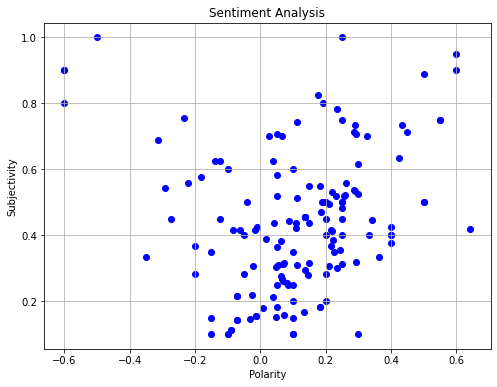

In [15]:
# Plot popularity and subjectivity
plt.figure(figsize=(8,6))
for i in range(df.shape[0]):
    plt.scatter(df['Polarity'][i], df['Subjectivity'][i], color='Blue')
    
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.grid(True)
plt.show()

## Train model

In [16]:
class Tokenizer:
  
  def clean(self, text):
      no_html = BeautifulSoup(text).get_text()
      clean = re.sub("[^a-z\s]+", " ", no_html, flags=re.IGNORECASE)
      return re.sub("(\s+)", " ", clean)

 
  def tokenize(self, text):
      clean = self.clean(text).lower()
      stopwords_en = stopwords.words("english")
      return [w for w in re.split("\W+", clean) if not w in stopwords_en]

In [17]:
class MultinomialNaiveBayes:
  
    def __init__(self, classes, tokenizer):
      self.tokenizer = tokenizer
      self.classes = classes
      
    def group_by_class(self, X, y):
      data = dict()
      for c in self.classes:
        data[c] = X[np.where(y == c)]
      return data
           
    def fit(self, X, y):
        self.n_class_items = {}
        self.log_class_priors = {}
        self.word_counts = {}
        self.vocab = set()

        n = len(X)
        
        grouped_data = self.group_by_class(X, y)
        
        for c, data in grouped_data.items():
          self.n_class_items[c] = len(data)
          self.log_class_priors[c] = math.log(self.n_class_items[c] / n)
          self.word_counts[c] = defaultdict(lambda: 0)
          
          for text in data:
            counts = Counter(self.tokenizer.tokenize(text))
            for word, count in counts.items():
                if word not in self.vocab:
                    self.vocab.add(word)

                self.word_counts[c][word] += count
                
        return self
      
    def laplace_smoothing(self, word, text_class):
      num = self.word_counts[text_class][word] + 1
      denom = self.n_class_items[text_class] + len(self.vocab)
      return math.log(num / denom)
      
    def predict(self, X):
        result = []
        for text in X:
          
          class_scores = {c: self.log_class_priors[c] for c in self.classes}

          words = set(self.tokenizer.tokenize(text))
          for word in words:
              if word not in self.vocab: continue

              for c in self.classes:
                
                log_w_given_c = self.laplace_smoothing(word, c)
                class_scores[c] += log_w_given_c
                
          result.append(max(class_scores, key=class_scores.get))

        return result

In [18]:
X = df['Tweets'].values
y = df['Sentiment'].values
RANDOM_SEED = 1
  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)


In [19]:
MNB = MultinomialNaiveBayes(
    classes=np.unique(y), 
    tokenizer=Tokenizer()
).fit(X_train, y_train)


In [27]:
y_hat = np.array(MNB.predict(X_test))
print(y_test)
print(y_hat)
print(type(y_hat[0]))
print(type(y_test[0]))

[0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
<class 'numpy.int32'>
<class 'numpy.int32'>


In [23]:
accuracy_score(y_test, y_hat)

ValueError: Classification metrics can't handle a mix of unknown and binary targets

In [ ]:
print(classification_report(y_test, y_hat))

In [ ]:
cnf_matrix = confusion_matrix(y_test, y_hat)
cnf_matrix

In [ ]:
class_names = ["negative", "positive"]
fig,ax = plt.subplots()


sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="Blues", fmt="d", cbar=False, xticklabels=class_names, yticklabels=class_names)
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.ylabel('Actual sentiment')
plt.xlabel('Predicted sentiment');